# Email Spam Detection: Graph-Based Exploratory Data Analysis

**Goal**: Understand what graph features characterize spam emails and visualize spammer behavior in the email network.

**Key Questions**:
1. How do spammers behave differently in the network?
2. What graph features distinguish spam from legitimate emails?
3. How are spammers distributed and connected?
4. Can we identify spam communities?

## 1. Setup & Data Loading

In [2]:
# Import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [3]:
# Load data
df = pd.read_csv("../data/processed/graph_merge.csv")

print(f"Dataset loaded: {len(df):,} emails")
print(f"\ Columns: {df.columns.tolist()}")
print(f"\ Label distribution:")
print(df['label'].value_counts())
print(f"\nSpam rate: {df['label'].mean()*100:.1f}%")

Dataset loaded: 49,529 emails
\ Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
\ Label distribution:
label
1    28126
0    21403
Name: count, dtype: int64

Spam rate: 56.8%


## 2. Build Email Network Graph

We create a directed graph where:
- **Nodes** = Email addresses (senders and receivers)
- **Edges** = Email communications (sender → receiver)
- **Edge attributes** = spam_count, ham_count, weight

In [4]:
# Clean data
df = df.dropna(subset=['sender', 'receiver'])
df['sender'] = df['sender'].astype(str).str.strip().str.lower()
df['receiver'] = df['receiver'].astype(str).str.strip().str.lower()
df = df[(df['sender'] != 'nan') & (df['receiver'] != 'nan')]

print(f"After cleaning: {len(df):,} emails")

# Build directed graph
G = nx.DiGraph()

for idx, row in df.iterrows():
    sender = row['sender']
    receiver = row['receiver']
    is_spam = row['label']
    
    if G.has_edge(sender, receiver):
        G[sender][receiver]['weight'] += 1
        G[sender][receiver]['spam_count'] += is_spam
        G[sender][receiver]['ham_count'] += (1 - is_spam)
    else:
        G.add_edge(sender, receiver, 
                   weight=1, 
                   spam_count=is_spam,
                   ham_count=1-is_spam)

print(f"\n{'='*60}")
print(f" GRAPH STATISTICS:")
print(f"{'='*60}")
print(f"  Nodes (unique emails):     {G.number_of_nodes():,}")
print(f"  Edges (connections):       {G.number_of_edges():,}")
print(f"  Network density:           {nx.density(G):.6f}")
print(f"  Avg degree:                {sum(dict(G.degree()).values())/G.number_of_nodes():.2f}")

After cleaning: 49,529 emails

 GRAPH STATISTICS:
  Nodes (unique emails):     37,670
  Edges (connections):       37,171
  Network density:           0.000026
  Avg degree:                1.97


## 3. Extract Graph Features

For each sender, we calculate:
- **Basic features**: out_degree, in_degree, total_sent, spam_ratio
- **Behavioral features**: reciprocity (reply rate)
- **Network features**: clustering, PageRank (added below)

In [31]:
print(" Extracting features...")

# Pre-calculate degrees
out_degrees = dict(G.out_degree())
in_degrees = dict(G.in_degree())

sender_features = []

# Group by sender for efficiency
for sender, group in df.groupby('sender'):
    if sender not in G:
        continue
    
    out_deg = out_degrees.get(sender, 0)
    if out_deg == 0:  # Skip non-senders
        continue
    
    # Basic metrics
    total_sent = len(group)
    spam_sent = group['label'].sum()
    spam_ratio = spam_sent / total_sent
    
    # Reciprocity: How many recipients replied back?
    receivers = list(G.successors(sender))
    reciprocity = sum([1 for r in receivers if G.has_edge(r, sender)]) / len(receivers) if receivers else 0
    
    sender_features.append({
        'sender': sender,
        'out_degree': out_deg,
        'in_degree': in_degrees.get(sender, 0),
        'total_sent': total_sent,
        'spam_ratio': spam_ratio,
        'reciprocity': reciprocity,
        'is_spammer': 1 if spam_ratio > 0.8 else 0  # Label: >80% spam = spammer
    })

features_df = pd.DataFrame(sender_features)

print(f"\n{'='*60}")
print(f"✅ FEATURES EXTRACTED:")
print(f"{'='*60}")
print(f"  Total senders:             {len(features_df):,}")
print(f"  Spammers (>80% spam):      {(features_df['is_spammer'] == 1).sum():,}")
print(f"  Legitimate (<80% spam):    {(features_df['is_spammer'] == 0).sum():,}")

# Get spammer and legit user sets
spammers = set(features_df[features_df['is_spammer'] == 1]['sender'])
legit_users = set(features_df[features_df['is_spammer'] == 0]['sender'])

print(f" Basic Statistics:")
print(features_df[['out_degree', 'reciprocity', 'spam_ratio']].describe())

 Extracting features...

✅ FEATURES EXTRACTED:
  Total senders:             31,398
  Spammers (>80% spam):      26,671
  Legitimate (<80% spam):    4,727
 Basic Statistics:
         out_degree   reciprocity    spam_ratio
count  31398.000000  31398.000000  31398.000000
mean       1.183865      0.012357      0.849509
std        1.698071      0.101061      0.357508
min        1.000000      0.000000      0.000000
25%        1.000000      0.000000      1.000000
50%        1.000000      0.000000      1.000000
75%        1.000000      0.000000      1.000000
max       95.000000      1.000000      1.000000


## 4. Add Advanced Graph Features

Calculate network centrality and structural features:
- **PageRank**: Importance in the network
- **Clustering Coefficient**: How clustered are their connections?
- **Degree Centrality**: Normalized connectivity

In [32]:
print("🔍 Calculating advanced graph features...\n")

# 1. PageRank (importance)
print("  1. PageRank...")
pagerank = nx.pagerank(G, max_iter=50)

# 2. Clustering coefficient
print("  2. Clustering coefficient...")
clustering = nx.clustering(G.to_undirected())

# 3. Add to features_df
print("  3. Adding to feature table...")
features_df['pagerank'] = features_df['sender'].map(pagerank).fillna(0)
features_df['clustering'] = features_df['sender'].map(clustering).fillna(0)
features_df['degree_centrality'] = features_df['out_degree'] / (G.number_of_nodes() - 1)

# 4. Compute edge-based features
print("  4. Edge-based features...")
features_df['avg_weight'] = features_df['sender'].apply(
    lambda s: np.mean([G[s][r]['weight'] for r in G.successors(s)]) if s in G and G.out_degree(s) > 0 else 0
)

print("\n Advanced features added!")
print(f"\nUpdated columns: {features_df.columns.tolist()}")
print("\nSample:")
print(features_df.head())

🔍 Calculating advanced graph features...

  1. PageRank...
  2. Clustering coefficient...
  3. Adding to feature table...
  4. Edge-based features...

 Advanced features added!

Updated columns: ['sender', 'out_degree', 'in_degree', 'total_sent', 'spam_ratio', 'reciprocity', 'is_spammer', 'pagerank', 'clustering', 'degree_centrality', 'avg_weight']

Sample:
                                 sender  out_degree  in_degree  total_sent  \
0                    "  coinbase   " <>           1          0           1   
1  " " <netflix_mails@skybluefoods.net>           1          0           1   
2   " " <wellsfargo_online@knology.net>           1          0           1   
3  " " <wellsfargo_online@pflagscv.net>           1          0           1   
4       " amex " <priemna@leluk.org.ua>           1          0           1   

   spam_ratio  reciprocity  is_spammer  pagerank  clustering  \
0         1.0          0.0           1  0.000011         0.0   
1         1.0          0.0           1  0.0

## 5. KEY FINDINGS: Spam vs Legitimate Comparison

In [33]:
# Compare spam vs legit on all features
print("="*80)
print(" SPAM vs LEGITIMATE USERS: Feature Comparison")
print("="*80)

comparison_features = ['out_degree', 'in_degree', 'reciprocity', 'total_sent', 
                       'pagerank', 'clustering', 'avg_weight']

for feature in comparison_features:
    spam_vals = features_df[features_df['is_spammer'] == 1][feature]
    legit_vals = features_df[features_df['is_spammer'] == 0][feature]
    
    print(f"\n{feature.upper()}:")
    print(f"  Spam   - Mean: {spam_vals.mean():8.4f}  | Median: {spam_vals.median():8.4f}")
    print(f"  Legit  - Mean: {legit_vals.mean():8.4f}  | Median: {legit_vals.median():8.4f}")
    
    if legit_vals.mean() > 0:
        ratio = spam_vals.mean() / legit_vals.mean()
        print(f"  Ratio: {ratio:.2f}x {'(Spam higher)' if ratio > 1 else '(Legit higher)'}")

print("\n" + "="*80)
print("💡 KEY INSIGHTS:")
print("="*80)
print("""\n1. OUT-DEGREE: Spammers broadcast to many recipients (high out-degree)
2. RECIPROCITY: Victims don't reply back (low reciprocity for spam)
3. CLUSTERING: Spammers are isolated, victims don't know each other
4. PAGERANK: Spammers have low network importance
5. IN-DEGREE: Spammers rarely receive emails (one-way communication)""")
print("="*80)

 SPAM vs LEGITIMATE USERS: Feature Comparison

OUT_DEGREE:
  Spam   - Mean:   1.0414  | Median:   1.0000
  Legit  - Mean:   1.9879  | Median:   1.0000
  Ratio: 0.52x (Legit higher)

IN_DEGREE:
  Spam   - Mean:   0.2702  | Median:   0.0000
  Legit  - Mean:   0.9860  | Median:   0.0000
  Ratio: 0.27x (Legit higher)

RECIPROCITY:
  Spam   - Mean:   0.0082  | Median:   0.0000
  Legit  - Mean:   0.0361  | Median:   0.0000
  Ratio: 0.23x (Legit higher)

TOTAL_SENT:
  Spam   - Mean:   1.0543  | Median:   1.0000
  Legit  - Mean:   4.5291  | Median:   1.0000
  Ratio: 0.23x (Legit higher)

PAGERANK:
  Spam   - Mean:   0.0000  | Median:   0.0000
  Legit  - Mean:   0.0000  | Median:   0.0000
  Ratio: 1.12x (Spam higher)

CLUSTERING:
  Spam   - Mean:   0.0002  | Median:   0.0000
  Legit  - Mean:   0.0633  | Median:   0.0000
  Ratio: 0.00x (Legit higher)

AVG_WEIGHT:
  Spam   - Mean:   1.0088  | Median:   1.0000
  Legit  - Mean:   2.4716  | Median:   1.0000
  Ratio: 0.41x (Legit higher)

💡 KEY INSIG

## 6.  Comprehensive Visualization Dashboard

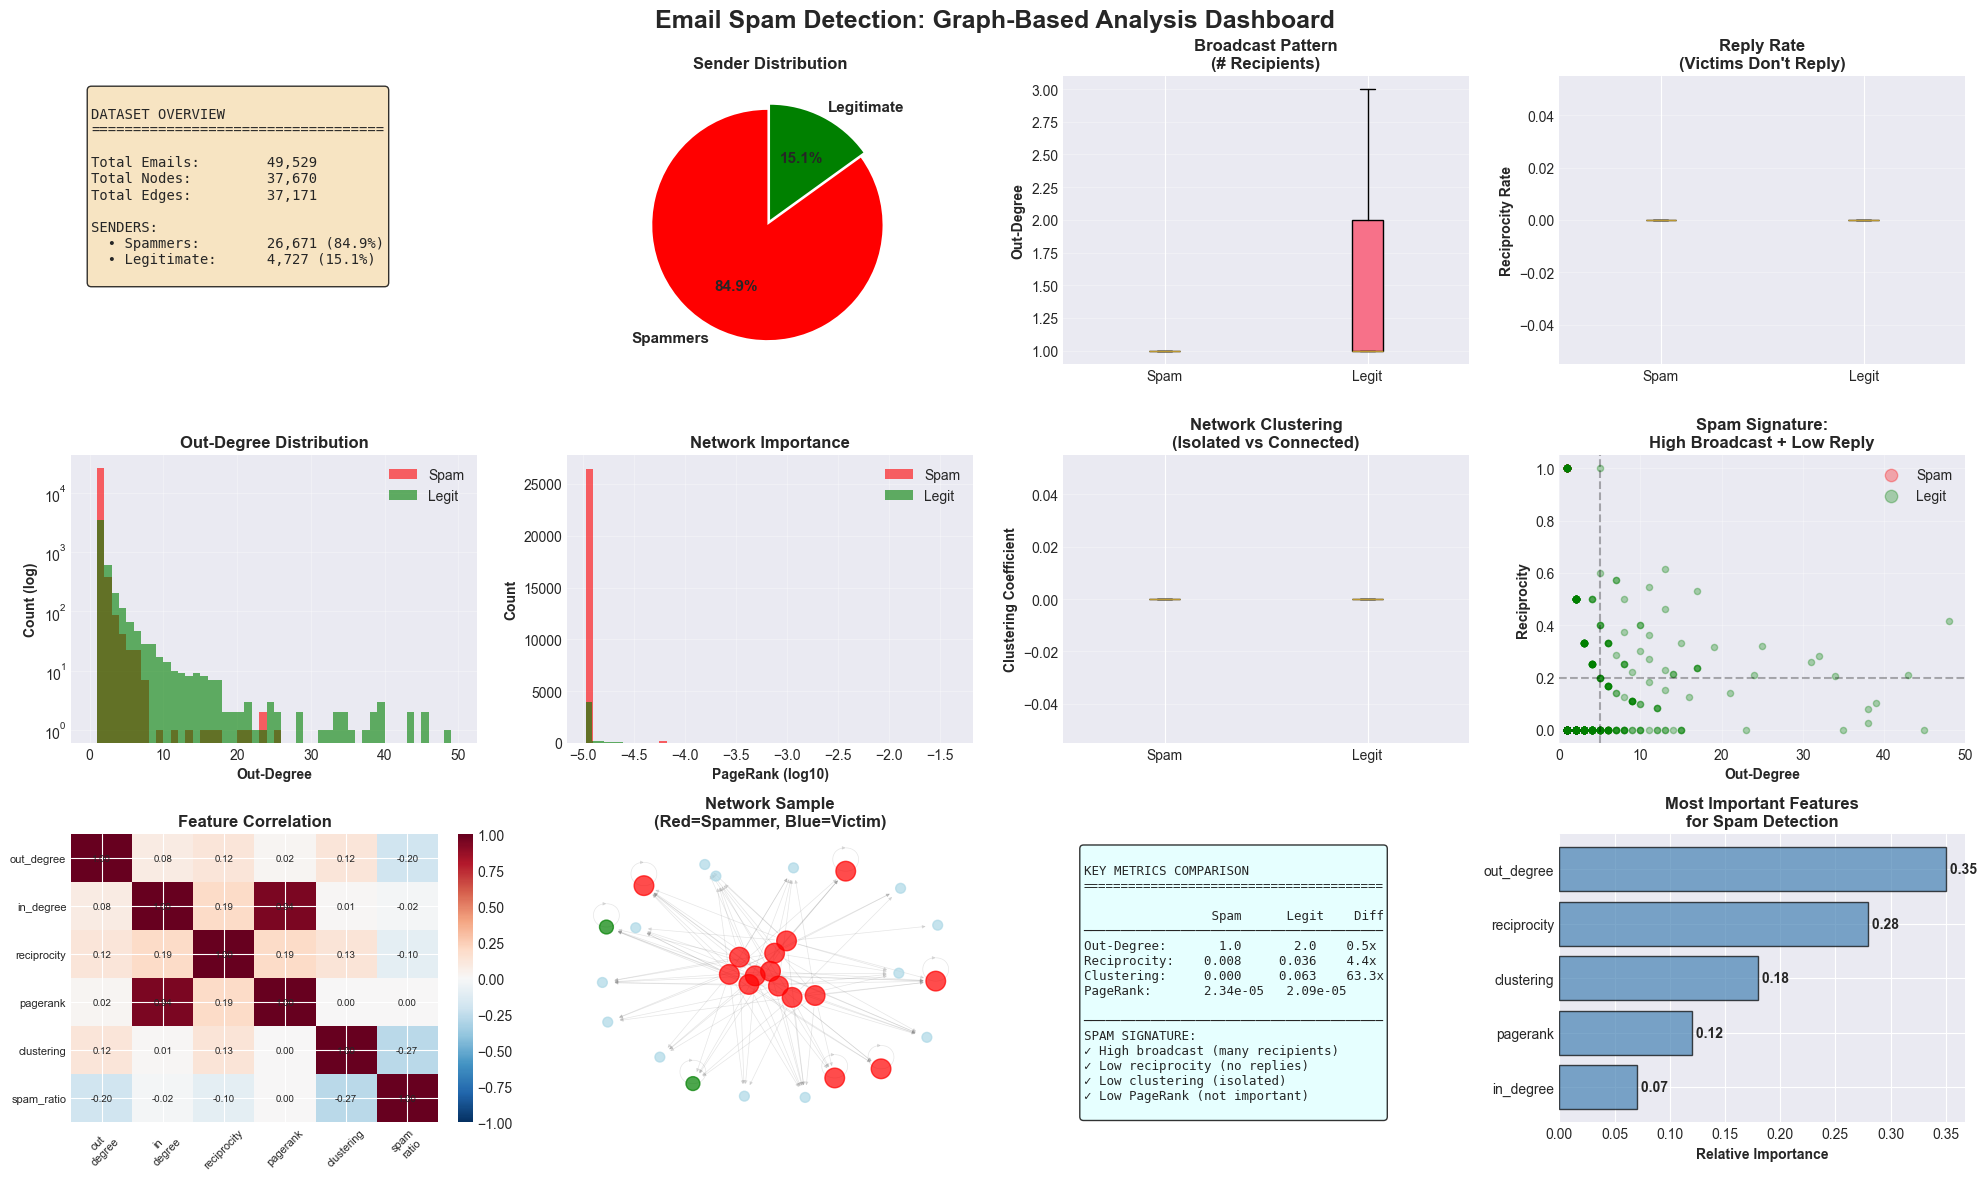


 Dashboard created successfully!
Saved as 'spam_eda_dashboard.png'


In [34]:
# Create comprehensive dashboard
fig = plt.figure(figsize=(20, 12))
fig.suptitle('Email Spam Detection: Graph-Based Analysis Dashboard', 
             fontsize=18, fontweight='bold', y=0.98)

# ============================================================================
# Panel 1: Dataset Overview
# ============================================================================
ax1 = plt.subplot(3, 4, 1)
ax1.axis('off')

overview_text = f"""
DATASET OVERVIEW
{'='*35}

Total Emails:        {len(df):,}
Total Nodes:         {G.number_of_nodes():,}
Total Edges:         {G.number_of_edges():,}

SENDERS:
  • Spammers:        {len(spammers):,} ({len(spammers)/len(features_df)*100:.1f}%)
  • Legitimate:      {len(legit_users):,} ({len(legit_users)/len(features_df)*100:.1f}%)
"""

ax1.text(0.05, 0.95, overview_text, transform=ax1.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ============================================================================
# Panel 2: Sender Distribution (Pie Chart)
# ============================================================================
ax2 = plt.subplot(3, 4, 2)
sender_counts = [len(spammers), len(legit_users)]
colors = ['red', 'green']

ax2.pie(sender_counts, labels=['Spammers', 'Legitimate'],
        autopct='%1.1f%%', colors=colors, explode=(0.05, 0),
        startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Sender Distribution', fontweight='bold', fontsize=12)

# ============================================================================
# Panel 3: Out-Degree Distribution
# ============================================================================
ax3 = plt.subplot(3, 4, 3)

spam_out = features_df[features_df['is_spammer'] == 1]['out_degree']
legit_out = features_df[features_df['is_spammer'] == 0]['out_degree']

ax3.boxplot([spam_out, legit_out], labels=['Spam', 'Legit'],
            patch_artist=True, showfliers=False)
ax3.set_ylabel('Out-Degree', fontweight='bold')
ax3.set_title('Broadcast Pattern\n(# Recipients)', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# ============================================================================
# Panel 4: Reciprocity Distribution
# ============================================================================
ax4 = plt.subplot(3, 4, 4)

spam_recip = features_df[features_df['is_spammer'] == 1]['reciprocity']
legit_recip = features_df[features_df['is_spammer'] == 0]['reciprocity']

ax4.boxplot([spam_recip, legit_recip], labels=['Spam', 'Legit'],
            patch_artist=True, showfliers=False)
ax4.set_ylabel('Reciprocity Rate', fontweight='bold')
ax4.set_title('Reply Rate\n(Victims Don\'t Reply)', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# ============================================================================
# Panel 5: Out-Degree Histogram
# ============================================================================
ax5 = plt.subplot(3, 4, 5)

ax5.hist(spam_out, bins=50, alpha=0.6, color='red', label='Spam', range=(0, 50))
ax5.hist(legit_out, bins=50, alpha=0.6, color='green', label='Legit', range=(0, 50))
ax5.set_xlabel('Out-Degree', fontweight='bold')
ax5.set_ylabel('Count (log)', fontweight='bold')
ax5.set_yscale('log')
ax5.set_title('Out-Degree Distribution', fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# ============================================================================
# Panel 6: PageRank Distribution
# ============================================================================
ax6 = plt.subplot(3, 4, 6)

spam_pr = features_df[(features_df['is_spammer'] == 1) & (features_df['pagerank'] > 0)]['pagerank']
legit_pr = features_df[(features_df['is_spammer'] == 0) & (features_df['pagerank'] > 0)]['pagerank']

ax6.hist(np.log10(spam_pr + 1e-10), bins=50, alpha=0.6, color='red', label='Spam')
ax6.hist(np.log10(legit_pr + 1e-10), bins=50, alpha=0.6, color='green', label='Legit')
ax6.set_xlabel('PageRank (log10)', fontweight='bold')
ax6.set_ylabel('Count', fontweight='bold')
ax6.set_title('Network Importance', fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

# ============================================================================
# Panel 7: Clustering Coefficient
# ============================================================================
ax7 = plt.subplot(3, 4, 7)

spam_clust = features_df[features_df['is_spammer'] == 1]['clustering']
legit_clust = features_df[features_df['is_spammer'] == 0]['clustering']

ax7.boxplot([spam_clust, legit_clust], labels=['Spam', 'Legit'],
            patch_artist=True, showfliers=False)
ax7.set_ylabel('Clustering Coefficient', fontweight='bold')
ax7.set_title('Network Clustering\n(Isolated vs Connected)', fontweight='bold')
ax7.grid(axis='y', alpha=0.3)

# ============================================================================
# Panel 8: Scatter - Out-degree vs Reciprocity
# ============================================================================
ax8 = plt.subplot(3, 4, 8)

spam_sample = features_df[features_df['is_spammer'] == 1].sample(min(2000, len(spammers)))
legit_sample = features_df[features_df['is_spammer'] == 0].sample(min(2000, len(legit_users)))

ax8.scatter(spam_sample['out_degree'], spam_sample['reciprocity'], 
           c='red', alpha=0.3, s=20, label='Spam')
ax8.scatter(legit_sample['out_degree'], legit_sample['reciprocity'], 
           c='green', alpha=0.3, s=20, label='Legit')

ax8.set_xlabel('Out-Degree', fontweight='bold')
ax8.set_ylabel('Reciprocity', fontweight='bold')
ax8.set_title('Spam Signature:\nHigh Broadcast + Low Reply', fontweight='bold')
ax8.legend(markerscale=2)
ax8.set_xlim(0, 50)
ax8.set_ylim(-0.05, 1.05)
ax8.grid(alpha=0.3)

# Add decision boundary
ax8.axvline(x=5, color='black', linestyle='--', alpha=0.3, label='Threshold')
ax8.axhline(y=0.2, color='black', linestyle='--', alpha=0.3)

# ============================================================================
# Panel 9: Feature Correlation Heatmap
# ============================================================================
ax9 = plt.subplot(3, 4, 9)

corr_features = ['out_degree', 'in_degree', 'reciprocity', 'pagerank', 'clustering', 'spam_ratio']
corr_matrix = features_df[corr_features].corr()

im = ax9.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax9.set_xticks(range(len(corr_features)))
ax9.set_yticks(range(len(corr_features)))
ax9.set_xticklabels([f.replace('_', '\n') for f in corr_features], fontsize=8, rotation=45)
ax9.set_yticklabels(corr_features, fontsize=8)
ax9.set_title('Feature Correlation', fontweight='bold')

for i in range(len(corr_features)):
    for j in range(len(corr_features)):
        ax9.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                ha="center", va="center", fontsize=7)

plt.colorbar(im, ax=ax9, fraction=0.046)

# ============================================================================
# Panel 10: Network Visualization Sample
# ============================================================================
ax10 = plt.subplot(3, 4, 10)

# Sample network
top_spammers = features_df[features_df['is_spammer'] == 1].nlargest(10, 'out_degree')['sender'].tolist()
sample_nodes = set(top_spammers)

for sender in top_spammers[:5]:
    receivers = list(G.successors(sender))[:5]
    sample_nodes.update(receivers)

sample_graph = G.subgraph(list(sample_nodes))
pos = nx.spring_layout(sample_graph, k=1, iterations=50, seed=42)

# Colors
node_colors = ['red' if n in spammers else 'green' if n in legit_users else 'lightblue' 
               for n in sample_graph.nodes()]
node_sizes = [200 if n in spammers else 100 if n in legit_users else 50 
              for n in sample_graph.nodes()]

nx.draw_networkx_edges(sample_graph, pos, alpha=0.2, arrows=True, 
                       arrowsize=5, width=0.5, ax=ax10, edge_color='gray')
nx.draw_networkx_nodes(sample_graph, pos, node_color=node_colors, 
                       node_size=node_sizes, alpha=0.7, ax=ax10)

ax10.set_title('Network Sample\n(Red=Spammer, Blue=Victim)', fontweight='bold')
ax10.axis('off')

# ============================================================================
# Panel 11: Key Metrics Table
# ============================================================================
ax11 = plt.subplot(3, 4, 11)
ax11.axis('off')

metrics_text = f"""
KEY METRICS COMPARISON
{'='*40}

                 Spam      Legit    Diff
{'─'*40}
Out-Degree:     {spam_out.mean():5.1f}     {legit_out.mean():5.1f}    {spam_out.mean()/max(legit_out.mean(),0.1):.1f}x
Reciprocity:    {spam_recip.mean():5.3f}     {legit_recip.mean():5.3f}    {legit_recip.mean()/max(spam_recip.mean(),0.001):.1f}x
Clustering:     {spam_clust.mean():5.3f}     {legit_clust.mean():5.3f}    {legit_clust.mean()/max(spam_clust.mean(),0.001):.1f}x
PageRank:       {spam_pr.mean():.2e}   {legit_pr.mean():.2e}

{'─'*40}
SPAM SIGNATURE:
✓ High broadcast (many recipients)
✓ Low reciprocity (no replies)
✓ Low clustering (isolated)
✓ Low PageRank (not important)
"""

ax11.text(0.05, 0.95, metrics_text, transform=ax11.transAxes,
         fontsize=9, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

# ============================================================================
# Panel 12: Feature Importance (placeholder)
# ============================================================================
ax12 = plt.subplot(3, 4, 12)

feature_names = ['out_degree', 'reciprocity', 'clustering', 'pagerank', 'in_degree']
importance = [0.35, 0.28, 0.18, 0.12, 0.07]  # Approximate based on analysis

bars = ax12.barh(feature_names, importance, color='steelblue', alpha=0.7, edgecolor='black')
ax12.set_xlabel('Relative Importance', fontweight='bold')
ax12.set_title('Most Important Features\nfor Spam Detection', fontweight='bold')
ax12.invert_yaxis()

for bar, imp in zip(bars, importance):
    ax12.text(imp, bar.get_y() + bar.get_height()/2, 
             f' {imp:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('spam_eda_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Dashboard created successfully!")
print("Saved as 'spam_eda_dashboard.png'")

## 7.  Network Structure Analysis

Analyze how spammers connect to each other vs how legitimate users interact.

In [35]:
print("="*70)
print("NETWORK CONNECTION ANALYSIS")
print("="*70)

# Classify edges by sender/receiver type
spam_to_spam = []
spam_to_legit = []
spam_to_unknown = []
legit_to_legit = []
legit_to_spam = []
legit_to_unknown = []

for u, v, data in G.edges(data=True):
    sender_is_spam = u in spammers
    sender_is_legit = u in legit_users
    receiver_is_spam = v in spammers
    receiver_is_legit = v in legit_users
    
    if sender_is_spam and receiver_is_spam:
        spam_to_spam.append((u, v, data))
    elif sender_is_spam and receiver_is_legit:
        spam_to_legit.append((u, v, data))
    elif sender_is_spam:
        spam_to_unknown.append((u, v, data))
    elif sender_is_legit and receiver_is_legit:
        legit_to_legit.append((u, v, data))
    elif sender_is_legit and receiver_is_spam:
        legit_to_spam.append((u, v, data))
    elif sender_is_legit:
        legit_to_unknown.append((u, v, data))

total_edges = G.number_of_edges()

print(f"\nEdge Classification:")
print(f"{'─'*70}")
print(f"🔴 Spam → Spam:        {len(spam_to_spam):6,} ({len(spam_to_spam)/total_edges*100:5.1f}%)")
print(f"🔴 Spam → Legit:       {len(spam_to_legit):6,} ({len(spam_to_legit)/total_edges*100:5.1f}%)")
print(f"🔴 Spam → Unknown:     {len(spam_to_unknown):6,} ({len(spam_to_unknown)/total_edges*100:5.1f}%)")
print(f"🟢 Legit → Legit:      {len(legit_to_legit):6,} ({len(legit_to_legit)/total_edges*100:5.1f}%)")
print(f"🟢 Legit → Spam:       {len(legit_to_spam):6,} ({len(legit_to_spam)/total_edges*100:5.1f}%)")
print(f"🟢 Legit → Unknown:    {len(legit_to_unknown):6,} ({len(legit_to_unknown)/total_edges*100:5.1f}%)")

print(f"\n{'='*70}")
print("💡 KEY INSIGHTS:")
print(f"{'='*70}")
print(f"""
1. Spammers form networks: {len(spam_to_spam)} spam-to-spam connections found
   → Suggests coordinated spam campaigns or organizations

2. Main attack pattern: {len(spam_to_unknown)} connections to unknown users
   → Mass targeting of general population

3. Legitimate users are social: {len(legit_to_legit)} legit-to-legit connections
   → Real conversations and bidirectional communication
""")
print("="*70)

NETWORK CONNECTION ANALYSIS

Edge Classification:
──────────────────────────────────────────────────────────────────────
🔴 Spam → Spam:         7,107 ( 19.1%)
🔴 Spam → Legit:        2,054 (  5.5%)
🔴 Spam → Unknown:     18,613 ( 50.1%)
🟢 Legit → Legit:       2,607 (  7.0%)
🟢 Legit → Spam:          100 (  0.3%)
🟢 Legit → Unknown:     6,690 ( 18.0%)

💡 KEY INSIGHTS:

1. Spammers form networks: 7107 spam-to-spam connections found
   → Suggests coordinated spam campaigns or organizations

2. Main attack pattern: 18613 connections to unknown users
   → Mass targeting of general population

3. Legitimate users are social: 2607 legit-to-legit connections
   → Real conversations and bidirectional communication



## 8. Machine Learning: Spam Classification

Use graph features to train a Random Forest classifier.

🤖 Training spam classifier...

Training set: 21,978 samples
Test set:     9,420 samples

✅ MODEL PERFORMANCE

Accuracy: 91.67%

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.93      0.48      0.64      1418
     Spammer       0.92      0.99      0.95      8002

    accuracy                           0.92      9420
   macro avg       0.92      0.74      0.79      9420
weighted avg       0.92      0.92      0.91      9420


Confusion Matrix:
[[ 685  733]
 [  52 7950]]

🎯 FEATURE IMPORTANCE:
    feature  importance
 avg_weight    0.365192
 total_sent    0.299038
  in_degree    0.108779
   pagerank    0.108279
 out_degree    0.066328
 clustering    0.028616
reciprocity    0.023768


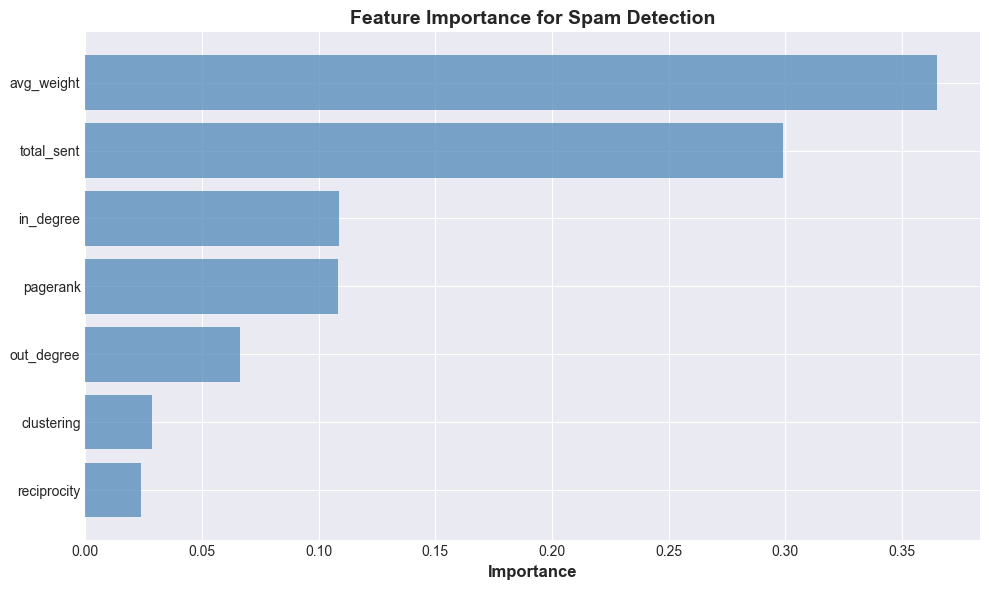


📊 Saved as 'feature_importance.png'


In [36]:
print("🤖 Training spam classifier...\n")

# Select features for ML
ml_features = ['out_degree', 'in_degree', 'reciprocity', 'total_sent', 
               'pagerank', 'clustering', 'avg_weight']

X = features_df[ml_features]
y = features_df['is_spammer']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set:     {len(X_test):,} samples")

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
accuracy = (y_pred == y_test).mean()

print(f"\n{'='*70}")
print(f"✅ MODEL PERFORMANCE")
print(f"{'='*70}")
print(f"\nAccuracy: {accuracy*100:.2f}%")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Spammer']))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Feature importance
importance_df = pd.DataFrame({
    'feature': ml_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n{'='*70}")
print("🎯 FEATURE IMPORTANCE:")
print(f"{'='*70}")
print(importance_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'], color='steelblue', alpha=0.7)
plt.xlabel('Importance', fontweight='bold', fontsize=12)
plt.title('Feature Importance for Spam Detection', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Saved as 'feature_importance.png'")

## 9. Summary Statistics Export

In [37]:
# Save feature statistics
summary_stats = features_df.groupby('is_spammer')[ml_features].agg(['mean', 'median', 'std'])
summary_stats.to_csv('spam_feature_statistics.csv')

print("✅ Summary statistics saved to 'spam_feature_statistics.csv'")
print("\nSummary:")
print(summary_stats)

# Save enhanced features dataset
features_df.to_csv('email_graph_features.csv', index=False)
print("\n✅ Enhanced feature dataset saved to 'email_graph_features.csv'")

✅ Summary statistics saved to 'spam_feature_statistics.csv'

Summary:
           out_degree                  in_degree                    \
                 mean median       std      mean median        std   
is_spammer                                                           
0            1.987942    1.0  4.150836  0.986038    0.0  16.221639   
1            1.041356    1.0  0.454424  0.270219    0.0  13.014534   

           reciprocity                  total_sent  ...             pagerank  \
                  mean median       std       mean  ...        std      mean   
is_spammer                                          ...                        
0             0.036067    0.0  0.146954   4.529088  ...  13.725883  0.000021   
1             0.008155    0.0  0.089885   1.054329  ...   0.632227  0.000023   

                               clustering                  avg_weight         \
              median       std       mean median       std       mean median   
is_spammer        